In [1]:
import datetime as dt
from authenticate import authenticate_google_calendar 


In [2]:
def fetch_study_events(service, calendar_id="primary", num_previous_days=30):
    now = dt.datetime.utcnow().isoformat() + "Z"  # 'Z' indicates UTC time
    # Calculate the start date X days before the current date
    start_date = dt.datetime.utcnow() - dt.timedelta(days=num_previous_days)
    start_date_iso = start_date.isoformat() + "Z"

    print(f"Fetching events from the past {num_previous_days} days")
    events_result = (
        service.events()
        .list(
            calendarId=calendar_id,
            timeMin=start_date_iso,
            timeMax=now,
            maxResults=10000,
            singleEvents=True,
            orderBy="startTime",
        )
        .execute()
    )
    events = events_result.get("items", [])

    if not events:
        print(f"No events found in the past {num_previous_days} days.")
        return []

    return events


Fetching events from the past 365 days
Total study time in the past 365 days: 2695.6499999999974 hours


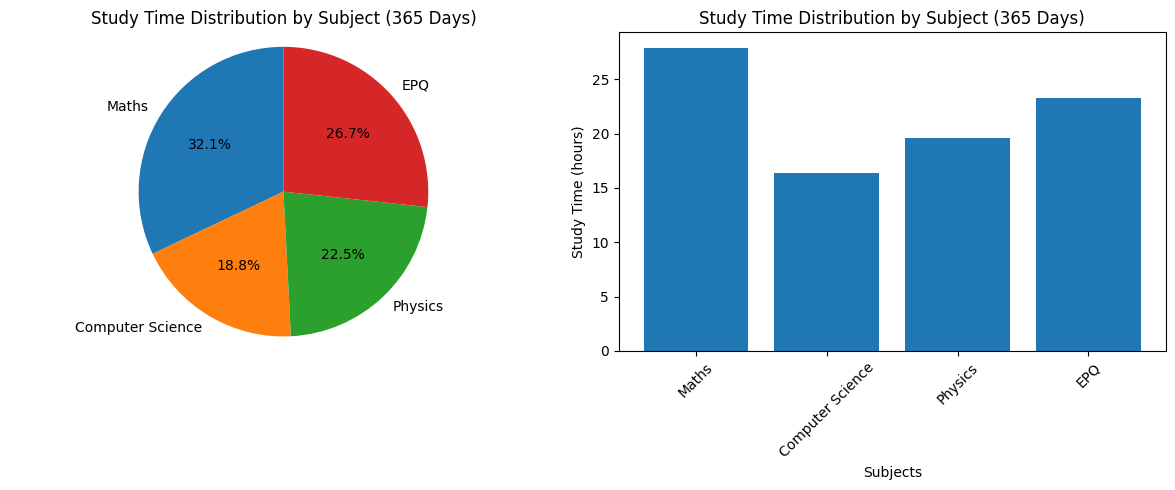

Fetching events from the past 30 days
Total study time in the past 30 days: 23.566666666666674 hours


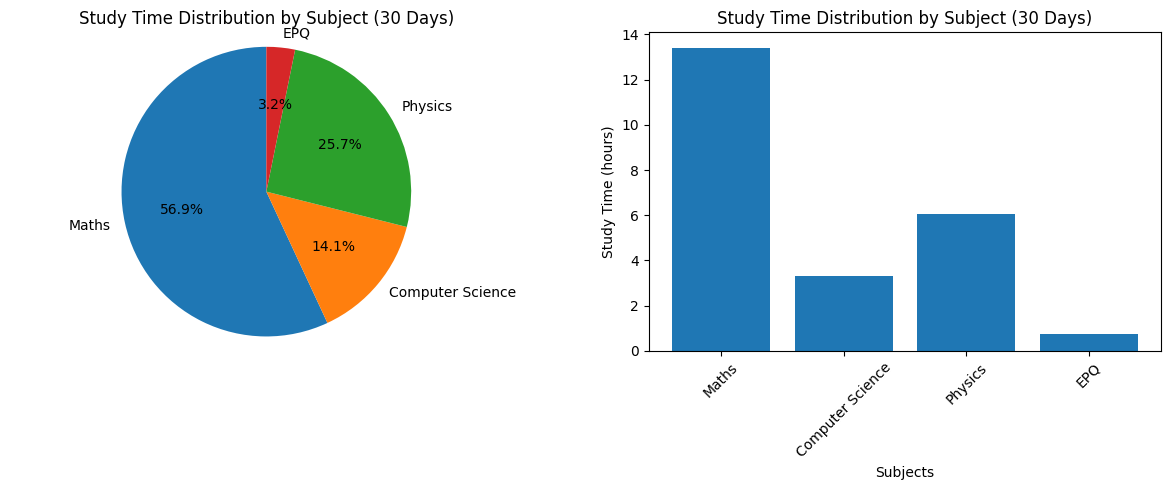

Fetching events from the past 7 days
Total study time in the past 7 days: 17.15 hours


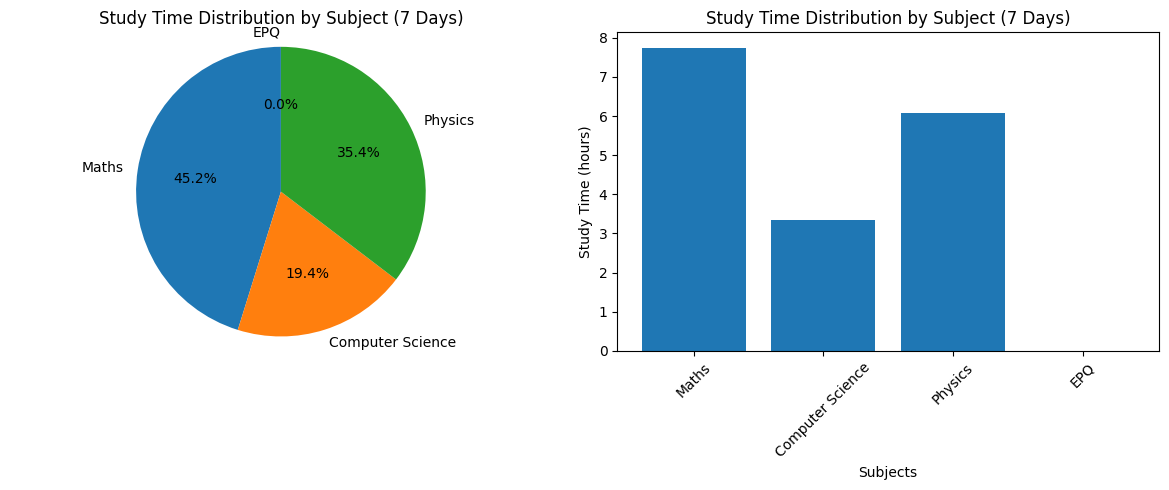

In [3]:
import matplotlib.pyplot as plt

def study_stats(service, calendar_id="primary", num_previous_days=365):
    events = fetch_study_events(service, calendar_id, num_previous_days)  # Fetch events for the specified number of previous days
    
    total_study_time = 0
    subjects = {
        "Maths": ["maths", "math", "mathematics"],
        "Computer Science": ["computer science", "comp sci"],
        "Physics": ["physics", "phys"],
        "EPQ": ["epq"],
        # "ICS": ["ics"],
    }
    subjects_time = {subject: 0 for subject in subjects.keys()}

    for event in events:
        start = dt.datetime.fromisoformat(
            event["start"].get("dateTime", event["start"].get("date"))
        )
        end = dt.datetime.fromisoformat(
            event["end"].get("dateTime", event["end"].get("date"))
        )
        duration = (end - start).total_seconds() / 3600  # Convert to hours
        total_study_time += duration

        summary = event.get("summary", "").lower()  # Convert to lowercase

        for subject, terms in subjects.items():
            for term in terms:
                if term in summary:
                    subjects_time[subject] += duration
                    break

    print(f"Total study time in the past {num_previous_days} days: {total_study_time} hours")

    # Generate pie chart and bar chart side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Pie chart
    ax1.pie(
        subjects_time.values(),
        labels=subjects_time.keys(),
        autopct="%1.1f%%",
        startangle=90,
    )
    ax1.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title(f"Study Time Distribution by Subject ({num_previous_days} Days)")

    # Bar chart
    ax2.bar(subjects_time.keys(), subjects_time.values())
    ax2.set_xlabel("Subjects")
    ax2.set_ylabel("Study Time (hours)")
    ax2.set_title(f"Study Time Distribution by Subject ({num_previous_days} Days)")
    ax2.tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

# Usage for different time frames
service = authenticate_google_calendar()
calendar_id = "0ca09266015f691eebe0d00c6f3ed7a784713e0160a694b8f7929add00cb1aa1@group.calendar.google.com"

# Show stats for the past 365 days
study_stats(service, calendar_id, num_previous_days=365)

# Show stats for the past 30 days
study_stats(service, calendar_id, num_previous_days=30)

# Show stats for the past 7 days
study_stats(service, calendar_id, num_previous_days=7)
